Inspect EDA results:

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [50]:
n_items = 100
n_selected = 10
n_generations = 100

In [51]:
# check pareto front
pareto_front_table = np.load(f'eda_results/pareto_front_table_{n_items}_{n_selected}_{n_generations}.npz')
pareto_front_last = pareto_front_table[f'gen_{n_generations}']

In [43]:
for i in range(n_generations):
    print(f'gen_{i+1}:', np.unique(pareto_front_table[f'gen_{i+1}'], axis=0).shape)

gen_1: (25, 4)
gen_2: (17, 4)
gen_3: (19, 4)
gen_4: (25, 4)
gen_5: (24, 4)
gen_6: (33, 4)
gen_7: (28, 4)
gen_8: (28, 4)
gen_9: (33, 4)
gen_10: (37, 4)
gen_11: (51, 4)
gen_12: (36, 4)
gen_13: (38, 4)
gen_14: (53, 4)
gen_15: (54, 4)
gen_16: (60, 4)
gen_17: (56, 4)
gen_18: (68, 4)
gen_19: (52, 4)
gen_20: (60, 4)
gen_21: (70, 4)
gen_22: (68, 4)
gen_23: (63, 4)
gen_24: (65, 4)
gen_25: (83, 4)
gen_26: (63, 4)
gen_27: (64, 4)
gen_28: (85, 4)
gen_29: (83, 4)
gen_30: (74, 4)
gen_31: (80, 4)
gen_32: (83, 4)
gen_33: (88, 4)
gen_34: (79, 4)
gen_35: (84, 4)
gen_36: (86, 4)
gen_37: (83, 4)
gen_38: (81, 4)
gen_39: (81, 4)
gen_40: (79, 4)
gen_41: (77, 4)
gen_42: (78, 4)
gen_43: (86, 4)
gen_44: (84, 4)
gen_45: (79, 4)
gen_46: (80, 4)
gen_47: (89, 4)
gen_48: (83, 4)
gen_49: (87, 4)
gen_50: (81, 4)


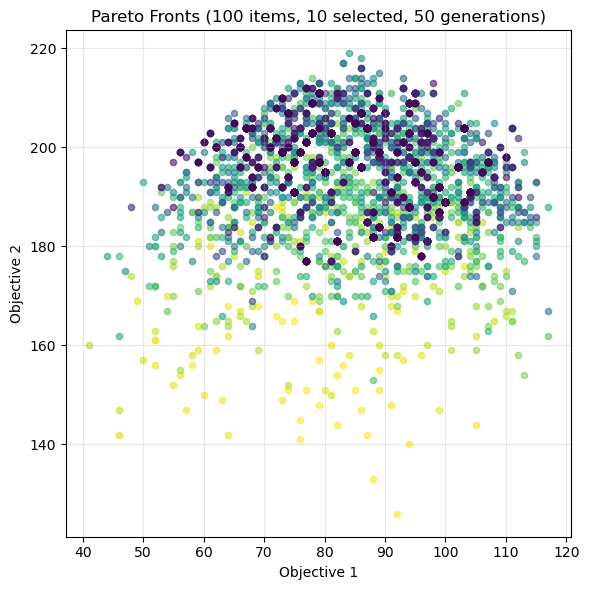

In [ ]:
# plot pareto fronts 2D
plt.figure(figsize=(6, 6))
plt.title(f'Pareto Fronts ({n_items} items, {n_selected} selected, {n_generations} generations)')
gen_plot = 50
colors = plt.cm.viridis_r(np.linspace(0, 1, gen_plot))

for i in range(n_generations - gen_plot, n_generations):
    pareto_front = pareto_front_table[f'gen_{i+1}']
    plt.scatter(pareto_front[:, 0], pareto_front[:, 1], 
                c=[colors[i-n_generations+gen_plot]], marker='o', s=20, alpha=0.6, 
                label=f'gen_{i+1}')

plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
# plt.xlim(0, 35)
# plt.ylim(0, 35)
# plt.legend()
plt.grid(True, alpha=0.3)   
plt.tight_layout()
plt.show()

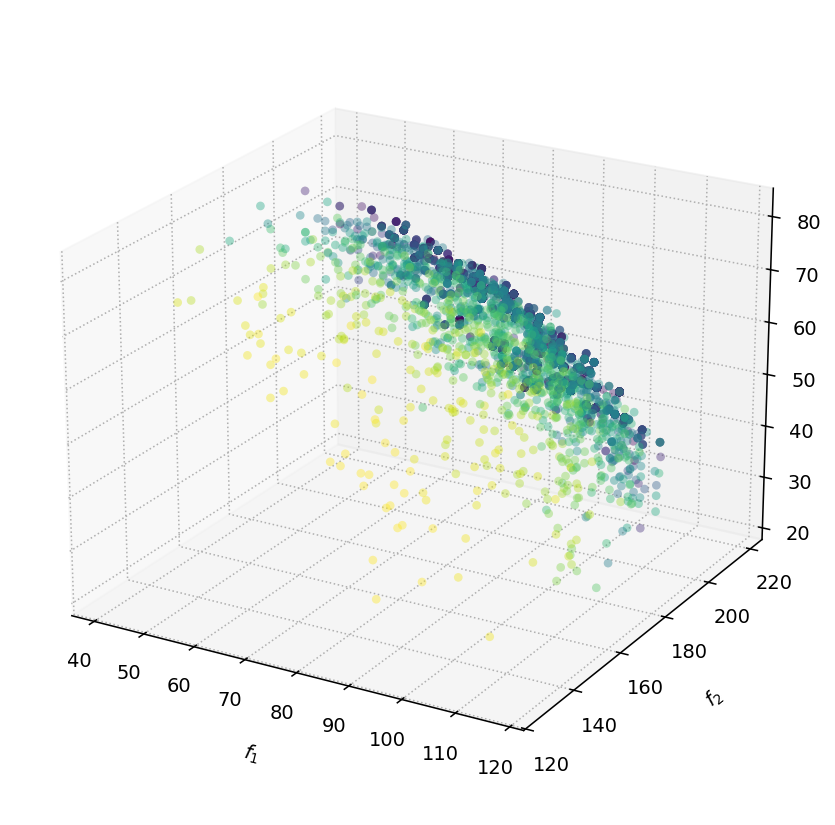

In [45]:
# plot pareto front 3D
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(8, 6), dpi=140)
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.viridis_r(np.linspace(0, 1, n_generations))

for i in range(n_generations):
    pareto_front = pareto_front_table[f'gen_{i+1}']
    ax.scatter(pareto_front[:, 0], pareto_front[:, 1], pareto_front[:, 2],
            marker='o', facecolors=colors[i], edgecolors='none', alpha=0.4,
            linewidths=1.5, s=20)

ax.set_xlabel(r'$f_1$', labelpad=10)
ax.set_ylabel(r'$f_2$', labelpad=10)
ax.set_zlabel(r'$f_3$', labelpad=10)

ax.xaxis._axinfo["grid"]['linestyle'] = ':'
ax.yaxis._axinfo["grid"]['linestyle'] = ':'
ax.zaxis._axinfo["grid"]['linestyle'] = ':'
ax.view_init(elev=22, azim=-60)

# ax.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

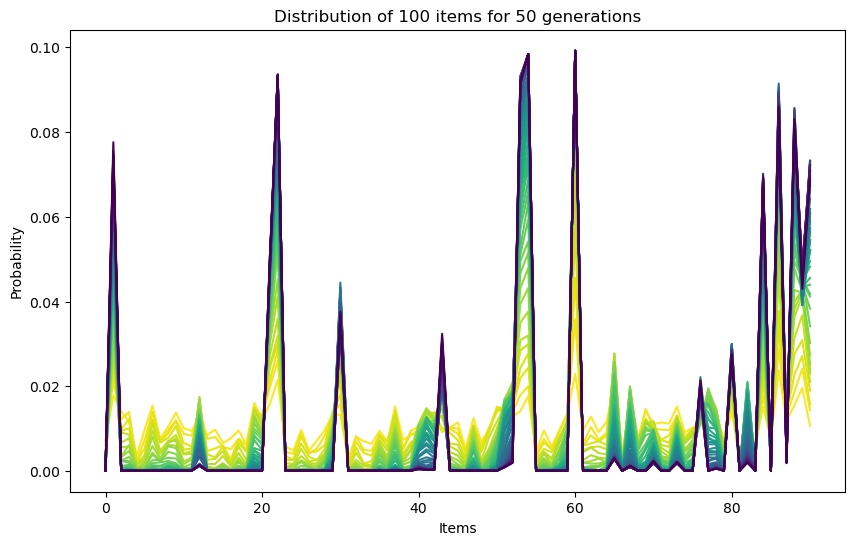

In [47]:
# check distribution
distribution_table = pd.read_csv(f'eda_results/distribution_table_{n_items}_{n_selected}_{n_generations}.csv')
distribution_table = distribution_table.drop(columns=["generation"]).to_numpy()
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis_r(np.linspace(0, 1, distribution_table.shape[0]))
for i in range(distribution_table.shape[0]):
    plt.plot(distribution_table[i, :], color=colors[i])
plt.xlabel('Items')
plt.ylabel('Probability')
plt.title(f'Distribution of {n_items} items for {distribution_table.shape[0]} generations')
plt.show()

    generation  js_divergence
0            1       0.006204
1            2       0.003821
2            3       0.002860
3            4       0.002981
4            5       0.002731
..         ...            ...
95          96       0.000048
96          97       0.000029
97          98       0.000030
98          99       0.000030
99         100       0.000022

[100 rows x 2 columns]


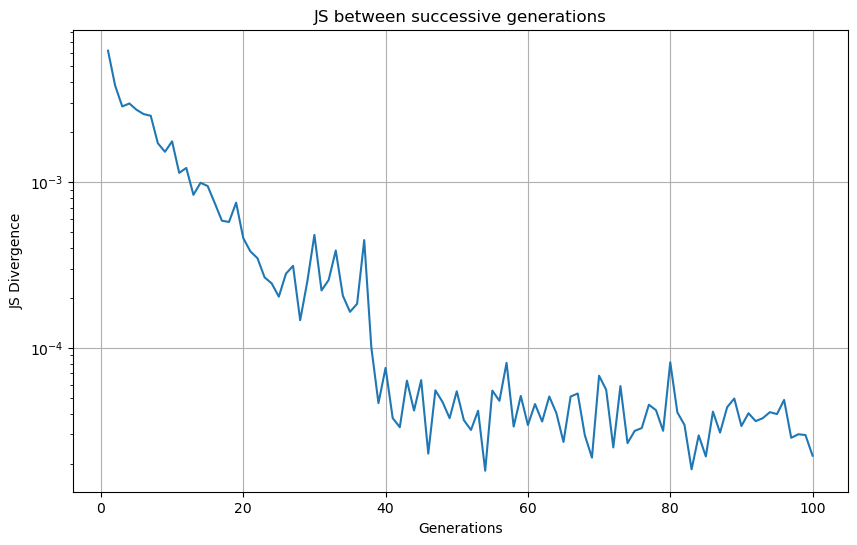

In [52]:
# check js divergence
js_div = pd.read_csv(f'eda_results/js_div_list_{n_items}_{n_selected}_{n_generations}.csv')
print(js_div)
plt.figure(figsize=(10, 6))
plt.plot(js_div["generation"], js_div["js_divergence"])
plt.xlabel('Generations')
plt.ylabel('JS Divergence')
plt.yscale('log')
plt.title('JS between successive generations')
plt.grid(True)
plt.show()

-----Below is EDA algorithm in jupyter notebook version-----

In [1]:
import numpy as np
from multitools import gamma_GC,make_pos_def
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import islice, combinations
from numpy import random
from scipy.spatial.distance import jensenshannon
rng = random.default_rng(seed = 1123)
item_rng = random.default_rng(seed = 1124)
import itertools as it
import pandas as pd

Generate items:

In [2]:
n_obj = 3
n_con = 1  # to simplify my coding i 
r = np.array([      
    [1.0, 0.4, -0.5, 0.3],
    [0.4, 1.0, 0.5, 0.4],
    [-0.5, 0.5, 1.0, 0.2],
    [0.3, 0.4, 0.2, 1.0],
])
r = make_pos_def(r)
shape, scale = [3.0, 4.0, 2.0, 8.0], [2.0, 3, 2,1.0]

In [3]:
n = 20
items = gamma_GC(r, n, shape, scale, rng=item_rng)

In [4]:
def cleanupsamples(samples,nobj,precision=1): 
    samples = np.round(samples, precision)
    c,i = np.unique(samples[:, :nobj], axis=0, return_index=True)

    newsamples = samples[i,:] #note - these have been sorted into increasing magnitude. 
    if precision==0:
        newsamples = np.array(newsamples, dtype='int8')
         
    return newsamples

items = cleanupsamples(items, n_obj, precision=0)

In [5]:
items

array([[ 2,  7,  5,  7],
       [ 2,  8,  7,  7],
       [ 2, 13,  9,  9],
       [ 3,  7,  3,  5],
       [ 3,  7,  4,  9],
       [ 3, 11,  6,  5],
       [ 3, 16, 10,  7],
       [ 4,  8,  4,  8],
       [ 4, 11,  5,  9],
       [ 5, 11,  3,  6],
       [ 5, 12,  3,  7],
       [ 5, 13,  3,  5],
       [ 6, 10,  5,  7],
       [ 6, 15,  5,  6],
       [ 8, 11,  3,  9],
       [ 8, 12,  3,  4],
       [ 9, 11,  2,  9],
       [ 9, 12,  4,  7],
       [11, 11,  1, 13],
       [16, 19,  2, 13]], dtype=int8)

EDA:

In [6]:
def get_objectives(samples, indices, nobj):
    objectives = np.zeros((indices.shape[0], nobj), dtype='int16')
    for j in range(indices.shape[0]):
        objectives[j,:] = np.sum(samples[indices[j], :nobj], axis=0, dtype='int16')
    return objectives

def get_constraints(samples, indices, nobj, ncon):
    constraints = np.zeros((indices.shape[0],ncon),dtype='int16')
    for j in range(indices.shape[0]):
        constraints[j,:] = np.sum(samples[indices[j],nobj:],axis=0,dtype='int16')
    constraints = np.squeeze(constraints)
    return constraints

In [7]:
def non_dominated_sort(objectives):
    n_solutions = objectives.shape[0]
    dominated_sets = [[] for _ in range(n_solutions)] # the set of solutions that p dominates
    domination_counts = [0] * n_solutions # the number of solutions that dominate p
    ranks = np.full(n_solutions, -1, dtype=int)           
    fronts = [[]]  

    for p in range(n_solutions):
        for q in range(n_solutions):
            if p == q:
                continue

            if np.all(objectives[p, :] >= objectives[q, :]) and \
                np.any(objectives[p, :] > objectives[q, :]):
                dominated_sets[p].append(q)
            elif np.all(objectives[q, :] >= objectives[p, :]) and \
                np.any(objectives[q, :] > objectives[p, :]):
                domination_counts[p] += 1 
        
        if domination_counts[p] == 0:
            ranks[p] = 0
            fronts[0].append(p)
    
    
    i = 0
    while i < len(fronts) and len(fronts[i]) > 0:
        next_front = []
        for p in fronts[i]:
            for q in dominated_sets[p]: 
                domination_counts[q] -= 1
                if domination_counts[q] == 0:
                    ranks[q] = i + 1
                    next_front.append(q)
        
        if next_front:
            fronts.append(next_front)
        i += 1

    dominated_sets = np.array([np.array(s, dtype=int) for s in dominated_sets], dtype=object)
    domination_counts = np.array(domination_counts, dtype=int)
    ranks = np.array(ranks, dtype=int)
    fronts = np.array([np.array(f, dtype=int) for f in fronts if len(f) > 0], dtype=object)

    return  dominated_sets, domination_counts, ranks, fronts


In [8]:
def assign_crowding_distance(objectives):
    distances = np.zeros(objectives.shape[0],  dtype=float)
    for m in range(np.shape(objectives)[1]):
        objective = objectives[:, m]
        sort_indices = np.argsort(objective)[::-1]
        sorted_objective = objective[sort_indices]
        min = sorted_objective[0]
        max = sorted_objective[-1]
        distances[sort_indices[0]] = np.inf
        distances[sort_indices[-1]] = np.inf
        for i in range(1, np.shape(objectives)[0] - 1):
            distances[sort_indices[i]] += (sorted_objective[i + 1] - sorted_objective[i - 1]) \
            / (max - min)
    return distances

In [9]:
def binary_tournament_selection(population, ranks, distances):
    indices = np.arange(len(population))
    i, j = rng.choice(indices, size=2, replace=False)
    if ranks[i] < ranks[j]:
        return i
    if ranks[j] < ranks[i]:
        return j
    else:
        if distances[i] > distances[j]:
            return i
        else:
            return j

In [10]:
def samplePopulation(samples, distribution, pop_size, n_selected, capacity):
    pop_count = 0
    population = np.zeros((pop_size, n_selected), dtype='int8')
    n_items = distribution.size

    while pop_count < pop_size:
        knapsack = rng.choice(n_items, n_selected, p=distribution, replace=False)
        constraint = np.sum(samples[knapsack, -1])
        if (constraint <= capacity):
            population[pop_count, :] = knapsack
            pop_count += 1

    return population

In [11]:
def generate_initial_population(items, capacity, n_selected, pop_size, n_obj):
    """
    Generate initial population and select population based on tournament selection.
    """
    n_items = items.shape[0]
    
    distribution = np.ones(n_items) / n_items
    population = samplePopulation(items, distribution, pop_size, n_selected, capacity)
    objectives = get_objectives(items, population, n_obj)

    _, _, ranks, fronts = non_dominated_sort(objectives)
    distances_all_solutions = np.zeros(population.shape[0], dtype=float)
    for f in fronts:
        distances = assign_crowding_distance(objectives[f, :])
        distances_all_solutions[f] = distances
    
    select_indices = np.array([], dtype=int)
    while len(select_indices) < pop_size:
        indice = binary_tournament_selection(population, ranks, distances_all_solutions)
        select_indices = np.concatenate([select_indices, np.array([indice])])
    
    selected_population = population[select_indices]
    selected_objectives = objectives[select_indices]
    
    distribution = np.ones(n_items)
    distribution += np.bincount(selected_population.flatten(), minlength=n_items)
    distribution /= np.sum(distribution)
    
    return distribution, selected_population, selected_objectives

In [12]:
def update_distribution(distribution, items, selected_population, selected_objectives, 
                        capacity, n_selected, pop_size, n_obj):
    """
    Update distribution, output current pareto front, and check convergence in a generation. 
    """
    population = samplePopulation(items, distribution, pop_size, n_selected, capacity)
    objectives = get_objectives(items, population, n_obj)

    # find current pareto front
    _, _, _, fronts_current = non_dominated_sort(objectives)
    pareto_indices = population[fronts_current[0]]

    objectives = np.vstack((selected_objectives, objectives))
    population = np.vstack((selected_population, population))
    
    _, _, ranks, fronts = non_dominated_sort(objectives)
    select_indices = np.array([], dtype=int)
    for f in fronts:
        if len(select_indices) + len(f) <= pop_size:
            select_indices = np.concatenate([select_indices, f])
        else:
            remaining_size = pop_size - len(select_indices)
            f_distance = assign_crowding_distance(objectives[f, :])
            sort_indices = np.argsort(f_distance)[::-1]
            remaining = f[sort_indices[:remaining_size]]
            select_indices = np.concatenate([select_indices, remaining])
            break
    
    selected_population = population[select_indices]
    selected_objectives = objectives[select_indices]
    
    n_items = items.shape[0]
    updated_distribution = np.ones(n_items)
    updated_distribution += np.bincount(selected_population.flatten(), minlength=n_items)
    updated_distribution /= np.sum(updated_distribution)

    # pareto_indices = population[fronts[0]]
    distribution[distribution < 1E-08] = 1E-08
    updated_distribution[updated_distribution < 1E-08] = 1E-08
    js_div = jensenshannon(distribution, updated_distribution)**2
    
    return updated_distribution, selected_population, selected_objectives, pareto_indices, js_div

In [13]:
def knapsack_eda(items, capacity, n_selected, n_obj, pop_size=1000, generations=100):
    """
    Main EDA function for knapsack problem.
    """
    n_items = items.shape[0]
    distribution = np.ones(n_items) / n_items
    distribution_table = []
    pareto_indices_table = []
    pareto_front_table = []
    js_div_list = []
    
    distribution, selected_population, selected_objectives = generate_initial_population(
        items, capacity, n_selected, pop_size, n_obj
    )

    for g in range(generations):
        distribution, selected_population, selected_objectives, pareto_indices, js_div = update_distribution(
            distribution, items, selected_population, selected_objectives,
            capacity, n_selected, pop_size, n_obj
        )
        
        pareto_front = np.zeros((pareto_indices.shape[0], items.shape[1]))
        for k in range(pareto_indices.shape[0]):
            pareto_front[k, :] = np.sum(items[pareto_indices[k, :], :], axis=0)
        
        distribution_table.append(distribution.copy())
        pareto_indices_table.append(pareto_indices.copy())
        pareto_front_table.append(pareto_front.copy())
        js_div_list.append(js_div)
    
    return distribution_table, pareto_indices_table, pareto_front_table, js_div_list  

In [14]:
n_items = items.shape[0]
n_selected  = 5
capacity = int(shape[-1]*scale[-1]*n_selected)
n_obj = 3
pop_size = 1000 #default
generations = 10 #default 
distribution_table, pareto_indices_table, pareto_front_table, js_div_list = knapsack_eda(items, capacity, n_selected, n_obj, pop_size=pop_size, generations=generations)

In [17]:
np.unique(pareto_front_table[-1], axis=0)

array([[16., 63., 37., 34.],
       [17., 63., 36., 38.],
       [18., 66., 35., 36.],
       [19., 62., 36., 36.],
       [19., 68., 33., 32.],
       [20., 65., 35., 34.],
       [22., 64., 35., 36.],
       [23., 67., 34., 34.],
       [24., 67., 33., 38.],
       [26., 66., 33., 36.],
       [30., 74., 32., 40.],
       [31., 68., 31., 40.],
       [32., 71., 30., 38.],
       [32., 76., 29., 40.],
       [35., 75., 29., 39.],
       [37., 73., 27., 38.],
       [38., 72., 28., 40.],
       [39., 75., 24., 38.],
       [40., 72., 26., 40.],
       [42., 74., 24., 37.],
       [44., 71., 17., 35.],
       [45., 68., 19., 37.],
       [47., 69., 17., 39.]])

In [ ]:
plt.plot(np.arange(1,generations+1,1),js_div_list)
plt.xlabel('Generations')
plt.ylabel('Jansen-Shannon Divergence')
plt.yscale('log')
plt.title('Jansen-Shannen Divergence between succeessive generations')
plt.show()